# DSCI 572 Lab 3

## Installations

You'll first need to install Keras and the TensorFlow backend, which should be possible with

```
pip install tensorflow
pip install keras
```

(I believe `conda` may also work for one or both packages.)

You can check that it's working by importing Keras below. If all is well, it should import successfully and print 
```
Using TensorFlow backend.
```

In [1]:
import keras

Using TensorFlow backend.


In [2]:
# keras imports
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import keras.datasets

In [3]:
# other imports
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier, MLPRegressor

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [4]:
plt.rcParams['font.size'] = 16

## Instructions
rubric={mechanics:10}

Follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).

## Exercise 0: neural networks "by hand"
rubric={reasoning:10}

Suppose that we use a neural network with one hidden layer and ReLU activations for a regression problem. After training, we obtain the following parameters:

$$\begin{align}W^{(0)} &= \begin{bmatrix}-2 & 2 & -1\\-1 & -2 & 0\end{bmatrix},  &b^{(0)}&=\begin{bmatrix}2 \\ 0\end{bmatrix} \\ W^{(1)} &= \begin{bmatrix}3 & 1\end{bmatrix},  &b^{(1)}&=-10\end{align}$$

For a training example with features $x = \begin{bmatrix}3 \\-2 \\ 2\end{bmatrix}$ what are the values in this network of $x^{(1)}$ and $\hat{y}$? Show your work.

## Exercise 1: digits warm-up

The code below loads scikit-learn's built-in handwritten digits dataset and fits the following classifiers:

- KNN
- random forest
- RBF SVM
- logistic regression
- 1-hidden-layer neural network using sklearn

In [5]:
digits = datasets.load_digits()
X, y = digits['data'], digits['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'valid samples')

1347 train samples
450 valid samples


In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [7]:
classifiers = {
    'knn'           : KNeighborsClassifier(),
    'random forest' : RandomForestClassifier(n_estimators=50),
    'SVM'           : SVC(C=100, gamma="scale"),
    'logistic reg'  : LogisticRegression(multi_class="multinomial", solver="lbfgs"),
    'sklearn NN'    : MLPClassifier() 
}

train_scores = dict()
valid_scores = dict()
training_times = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    classifier_obj.fit(X_train, y_train)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
    valid_scores[classifier_name] = classifier_obj.score(X_valid, y_valid)

Fitting knn
Fitting random forest
Fitting SVM
Fitting logistic reg
Fitting sklearn NN


In [8]:
pd.options.display.float_format = '{:,.2f}'.format # make things look prettier when printing
data = {"train acc": train_scores, "valid acc" : valid_scores, "training time (s)" : training_times}
df = pd.DataFrame(data, columns=data.keys())
df.index = list(classifiers.keys())
df

,train acc,valid acc,training time (s)
knn,1.00,0.98,0.10
random forest,0.99,0.98,0.01
SVM,1.00,0.98,0.13
logistic reg,1.00,0.98,0.17
sklearn NN,1.00,0.98,1.60


As you can see, this dataset isn't very exciting in the sense that most of the methods get a high test accuracy after very little time. We'll use this dataset for a few more moments, and then move onto another one soon.

### 1(a)
rubric={accuracy:5}

Using Keras, create a neural network with the same architecture as the sklearn NN above. You'll need to deal with one-hot encoding of the labels, since this is how Keras expects the data. Briefly discuss your results.

Warning: it has happened to students in the past that Keras caused their system to hang (not sure why). If this happens, I suggest (1) moving the Keras code outside of Jupyter into a regular `.py` file and (2) saving your work frequently. (But hopefully this was a known bug that has been fixed in the last year and won't be an issue anymore.)

### 1(b)
rubric={viz:5}

For the same network above, make the following two plots:

1. A plot of accuracy vs. optimization epochs. You should have two curves on this plot, one of train and one for test.
2. A plot of the loss vs. optimization epochs. You should have two curves on this plot, one of train and one for test.

Some notes:

- To get access to this information, you can use the history object that is returned by `fit`. 

- If you're wondering what the difference is, accuracy is the percentage of examples that are correctles classified (always between $0$ and $1$), whereas the loss is literally the function being optimized (like `loss_lr` in lab 1, not necessarily between $0$ and $1$). The loss can't just be the number of incorrectly classifier examples, since this isn't a continuous function and would be too hard to optimize. More on this coming in DSCI 573. 

### 1(c)
rubric={reasoning:5,quality:5}

The optimization problem of training a neural network is non-convex. To explore this, try training
your network several times. You will get different results due to different random initializations and different randomness in the optimization method itself. Explore how the training/validation error changes across
runs.

### (optional) 1(d) 
rubric={reasoning:1}

Continuing with the above, try also exploring how the model parameters themselves (the weights) change across runs (you'll need to think of a reasonable way of comparing the weights of two networks).
Do you observe substantially different weight sets all with a similar prediction accuracy... or something different?

Note: to inspect the weights themselves, use the `get_weights()` function for the Keras model/layer object. I also provide a function, below, that grabs all the weights of a trained model and puts them in one big flat numpy array:

In [22]:
get_all_weights = lambda model: np.concatenate(tuple(map(lambda wi: wi.flatten(), model.get_weights())))

## Exercise 2: big digits

Next, we'll move on to the famous the MNIST digits -- a classic dataset for deep learning. The MNIST data set is  bigger than the digits dataset built into sklearn: the images are larger ($28\times28$ instead of $8\times8$) and there are more of them ($70000$ insetad of $1797$). In total, we're dealing with $70000\times28\times28\approx 55$ million training pixels instead of $1797\times8\times8\approx80000$ training pixels (about $500$ times more data). 

If you're interested, check out [this site](http://yann.lecun.com/exdb/mnist/) showing the progress on this dataset from 1998 to 2012. 

The following code loads the MNIST dataset. The first time you run it, the data will be downloaded. In future times, it will use the local version.

In [29]:
# the data, shuffled and split between train and test sets
(X_train_img, y_train), (X_test_img, y_test) = keras.datasets.mnist.load_data()

In [30]:
X_train_img.shape

(60000, 28, 28)

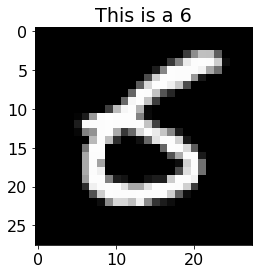

In [31]:
# display a random training example
i = np.random.randint(0,len(X_train_img))
plt.imshow(X_train_img[i],cmap='gray')
plt.title('This is a %d' % y_train[i]);

In [32]:
X_train = X_train_img.reshape(60000, 28*28)
X_test = X_test_img.reshape(10000, 28*28)
X_train = X_train / 255 # this is the same a scaling, since the pixel intensities range from 0 to 255
X_test = X_test / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### 2(a)
rubric={reasoning:15}

1. Which of the classifiers from Exercise 1 scale well to this larger data set? You are free to make arguments using theory (big-O running times) and/or experiment (timed runs) as you see fit. Keep in mind that we've increased both $n$ (number of examples) and $d$ (number of features). Don't subject yourself to experiments that take tens of minutes or hours. It is fine to declare defeat after a couple of minutes and say that a method doesn't scale. But, when that happens, try to say a little bit about why that might be the case. 
2. For those methods where the running time is reasonable (say, a couple minutes of computation), how does the accuracy compare between the methods?


### 2(b)
rubric={reasoning:15}

The code below runs a bigger Keras model on the full MNIST data set. 

In [35]:
batch_size = 128
num_classes = 10
epochs = 5

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test))

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

elapsed_time = time.time()-start_time
print("---Running Time: %s seconds ---" % elapsed_time)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.2633 - acc: 0.9231 - val_loss: 0.1293 - val_acc: 0.9618
Epoch 2/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.0978 - acc: 0.9710 - val_loss: 0.0899 - val_acc: 0.9707
Epoch 3/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.0627 - acc: 0.9803 - val_loss: 0.0738 - val_acc: 0.9760
Epoch 4/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.0460 - acc: 0.9849 - val_loss: 0.0766 - val_acc: 0.9755
Epoch 5/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.0326 - acc: 0.9891 - val_loss: 0.0859 - val_acc: 0.9740
Train accuracy: 0.9891333333333333
Test accuracy: 0.974
---Running Time: 37.09114193916321 seconds ---


For the neural network implemented with Keras above, explore the effects of the different hyperparameters on accuracy. Try at least 3 variations on what you're given above. In each case, briefly discuss your results. Some things you can consider trying:
  - adding/removing layer(s)
  - changing the [activation functions](https://keras.io/activations/) from `relu` to `tanh`
  - adding [regularization](https://keras.io/regularizers/) such as dropout
  - changing the way the weights are [initialized](https://keras.io/initializations/)
  - changing the [optimizer](https://keras.io/optimizers/) from adam to something else, like SGD. Read the documentation and try changing the _hyperparameters of the optimizer_ in addition to just the type of optimizer (e.g., $\alpha$ in gradient descent is a hyperparameter of the optimizer). It should not be difficult to completely mess up your training procedure, for example by tampering with the learning rate.

**NOTE: if at any point things are just way too slow, you can use a subset of the data to speed things up. But try to still draw interesting conclusions to the extent possible.**

## Exercise 3: pondering neural networks
rubric={reasoning:15}

1. Explain why a 1-layer (zero-hidden-layer) neural network with a linear activation is equivalent to linear regression. If you just wanted to do linear regression, what are the disadvantages of using Keras instead of a package like R's `lm`?
2. Consider a regression problem with $d=500$ features. You use a 2-hidden-layer neural network with hidden layer sizes $100$ and $200$. How many parameters does the model have? Justify your answer.
3. Name one advantage and one disadvantage of stochastic gradient descent, when comparing it to gradient descent?
4. Hyperparameter optimization would be easy if we could independently tune each hyperparameter. Then, with $m$ hyperparameters, we'd just have $m$ one-dimensional optimization problems. However, in reality the hyperparameters interact, which leaves you with the more daunting $m$-dimensional optimization problem. Consider for example a regularization hyperparameter (like dropout) and an architecture parameter (like the number of units or layers). Why do you think these hyperparameters would "interact" with each other? What combinations do you think might lead to better or worse performance? 
5. If you look at the [documentation for scikit-learn's neural network classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), you'll see that the user only needs to input the sizes of the hidden layers; like other scikit-learn classifiers, there's no need for the user to explicitly enter the number of features when creating the model object. However, Keras requires us to set the `input_dim` argument in the first `Dense` layer, which specifies the number of features. Why do you think Keras requires this whereas scikit-learn doesn't?

## Exercise 4
rubric={reasoning:5}

It should be the case that logistic regression is equivalent to a neural network with no hidden layers. Using sklearn's `MLPClassifier`, fit a zero-hidden-layer neural network on the synthetic 2D data (generated below) and compare the learned weights to what you get with `LogisticRegression`. Do you get essentially the same model with the neural network? You'll need to fiddle with the hyperparameters (optimization, regularization) to get something equivalent. 

If you want to be very careful, see if you can get the coefficients to be exactly the same up to several decimal places (I managed to do this).  However, this might not be a good use of your time.

In [ ]:
n = 100
d = 2
X = np.random.rand(n,2)
y = np.random.rand(n) > 0.7
X[y==0,0] += .7
X[y==0,1] += .3

### (optional) Exercise 4(b)
rubric={reasoning:1}

Try to get the above working with Keras as well. I tried for about 20 minutes and wasn't successful (speaking of questionable uses of time...), so if you figure it out please send me a message and I'll add your solution to the official solutions. Some reasons why this is annoying:

- One has to be very careful with the (L2) regularization. The interpretation of the regularization strength may vary across packages. It might be easier to turn off regularization for both.
- It's not clear whether to use a `softmax` activation + `categorical_crossentropy` loss + one-hot enoded labels or `sigmoid` activation + `binary_crossentropy` loss + regular labels. I have slightly more faith in the former approach. For this reason, it might be easier to first try and get this working with linear regression, and then move on to logistic.
- The SGD-based optimizers available in Keras aren't well suited to this kind of toy dataset.

## (optional) Exercise 5: backprop
rubric={reasoning:1}

From scratch using only raw numpy, implement a one-hidden-layer neural network for regression using ReLUs. Show your computation of the gradients alongside the code. You can ignore the fact that the ReLU function is not differentiable when its input equals zero.

NOTE: there are probably a lot of resources out there where people give their "raw" neural network implementations. If you're going to do this and you consult any sources, make sure you cite them. 